### Imports

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from typing import Iterable, Union
from toggle import hide_toggle
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from get_data import get_training, get_test
from learning import fit, evaluate, plot_history
from plots import plot_features, plot_compare_features


from numpy.random import seed
seed(9849)
from tensorflow import set_random_seed
set_random_seed(6432)

hide_toggle()

In [2]:
def create_model(sample_shape: Iterable,
                 no_classes: int, kernel1:Iterable, kernel2:Iterable, conv_filt: int, dense_filt: int,
                 optimizer = 'adam', loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(conv_filt, kernel_size = kernel1,input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D(kernel2))
    model.add(Dropout(0.5))
    model.add(Dense(dense_filt, activation='relu')) #kolejne relu
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
    return model

# Loading data

In [3]:
# dire = "./npy_data/"
# dire = "./npy_data2/"
# dire = "./npy_data3/"
dire = "./npy_data_mix/"

# class_no8 = np.load(dire+'class_no8.npy')
# data_no8 = np.load(dire+'data_no8.npy')


# class_no13 = np.load(dire+'class_no13.npy')
# data_no13 = np.load(dire+'data_no13.npy')

# class_no18 = np.load(dire+'class_no18.npy')
# data_no18 = np.load(dire+'data_no18.npy')

# class_no23 = np.load(dire+'class_no23.npy')
# data_no23 = np.load(dire+'data_no23.npy')

# class_no28 = np.load(dire+'class_no28.npy')
# data_no28 = np.load(dire+'data_no28.npy')

# class_no33 = np.load(dire+'class_no33.npy')
# data_no33 = np.load(dire+'data_no33.npy')
class_no8 = np.load(dire+'class_no0.npy')
data_no8 = np.load(dire+'data_no0.npy')


class_no13 = np.load(dire+'class_no1.npy')
data_no13 = np.load(dire+'data_no1.npy')

class_no18 = np.load(dire+'class_no2.npy')
data_no18 = np.load(dire+'data_no2.npy')

class_no23 = np.load(dire+'class_no3.npy')
data_no23 = np.load(dire+'data_no3.npy')

class_no28 = np.load(dire+'class_no4.npy')
data_no28 = np.load(dire+'data_no4.npy')

class_no33 = np.load(dire+'class_no5.npy')
data_no33 = np.load(dire+'data_no5.npy')

hide_toggle()

In [21]:
data_no33.shape

(5, 4500, 19, 77)

## Picture options - time x freq bands or time x channels

In [22]:
freq_bands = 'ijkl->jlik' #better
channels = 'ijkl->jlki'
option = freq_bands

## Prepared combinations

In [23]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [24]:
batch_size = 200
no_epochs = 30
verbosity = 1
loss_fun = 'binary_crossentropy'

In [34]:
out_alpha = [0,1,2,3]
out_Pz = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

## Datasets

In [35]:
combination = 1

'''Train'''
X_train, y_train = get_training(X, y, combinations_train[combination], option)

'''Test'''
X_test, y_test = get_test(X, y, combinations_test[combination], option)

'''Validation'''
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

# '''Cutting edges'''
# X_train = X_train[:,5:71,:,:]
# X_test = X_test[:,5:71,:,:]
# X_validation = X_validation[:,5:71,:,:]

'''Cutting edges, alpha, Pz'''
X_train = X_train[:,5:71,out_alpha,:]
X_test = X_test[:,5:71,out_alpha,:]
X_validation = X_validation[:,5:71,out_alpha,:]

X_train = X_train[:,:,:,out_Pz]
X_test = X_test[:,:,:,out_Pz]
X_validation = X_validation[:,:,:,out_Pz]

sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])


In [36]:
X_train.shape

(17956, 66, 4, 18)

In [37]:
print(f' Average count of trials (per participant): {(X_validation.shape[0] + X_test.shape[0] + X_train.shape[0] )/ 33} ; Total count of trials: {X_validation.shape[0] + X_test.shape[0] + X_train.shape[0]}')

 Average count of trials (per participant): 906.3939393939394 ; Total count of trials: 29911


## Learning

In [38]:
"Creating model"
model = create_model(sample_shape, 2, (11,1), (11,1), 30, 50, optimizer='adam')

"Fitting model to data"
fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
            batch_size, no_epochs)

Train on 17956 samples, validate on 4491 samples
Epoch 1/30
17956/17956 [==============================] - 2s 96us/sample - loss: 0.7128 - acc: 0.5133 - val_loss: 0.6845 - val_acc: 0.5549
Epoch 2/30
17956/17956 [==============================] - 2s 92us/sample - loss: 0.6927 - acc: 0.5351 - val_loss: 0.6828 - val_acc: 0.5680
Epoch 3/30
17956/17956 [==============================] - 2s 94us/sample - loss: 0.6874 - acc: 0.5517 - val_loss: 0.6804 - val_acc: 0.5645
Epoch 4/30
17956/17956 [==============================] - 2s 90us/sample - loss: 0.6856 - acc: 0.5516 - val_loss: 0.6777 - val_acc: 0.5720
Epoch 5/30
17956/17956 [==============================] - 2s 91us/sample - loss: 0.6832 - acc: 0.5617 - val_loss: 0.6758 - val_acc: 0.5812
Epoch 6/30
17956/17956 [==============================] - 2s 90us/sample - loss: 0.6823 - acc: 0.5586 - val_loss: 0.6788 - val_acc: 0.5803
Epoch 7/30
17956/17956 [==============================] - 2s 91us/sample - loss: 0.6806 - acc: 0.5645 - val_loss: 0.6

## Evaluating

Test loss: 0.6815656005761248 / Test accuracy: 0.5637727975845337


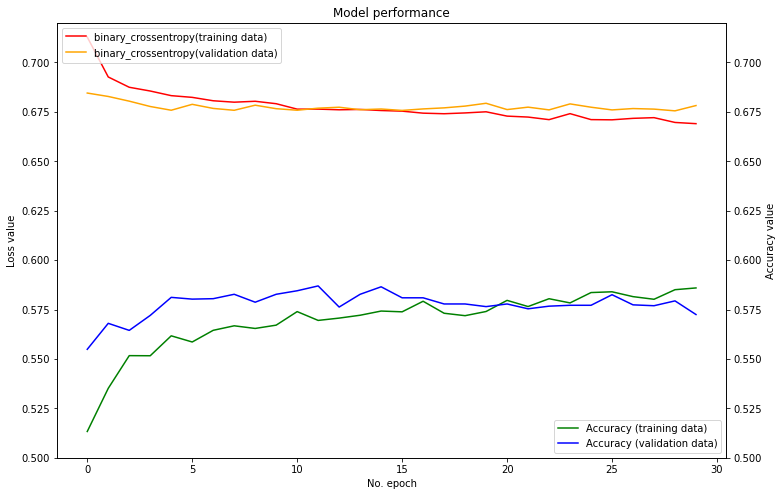

In [39]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation, y_validation)

"Plotting history"
plot_history(hist, loss_fun)

# Filters visualization

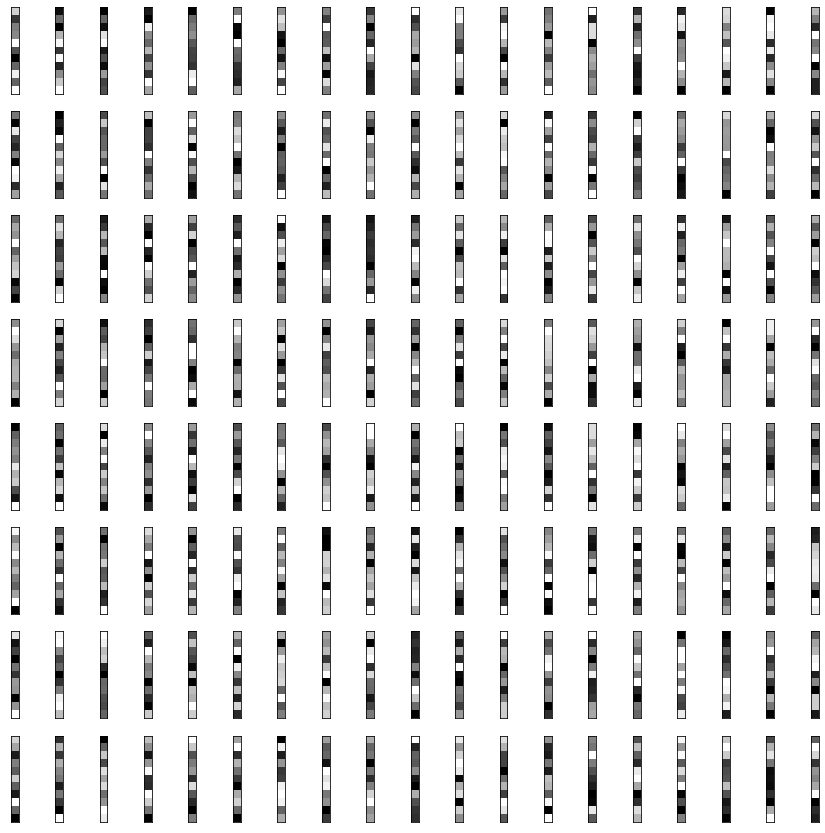

In [40]:
from matplotlib import pyplot

filters, biases = fitted_model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 8, 1
pyplot.figure(figsize = (15,15))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(19):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 19, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

# Feature map visualization

In [41]:
filters = 8
outputs = [fitted_model.layers[0].output]
model = Model(inputs=fitted_model.inputs, outputs=outputs)

### Feature map for one example

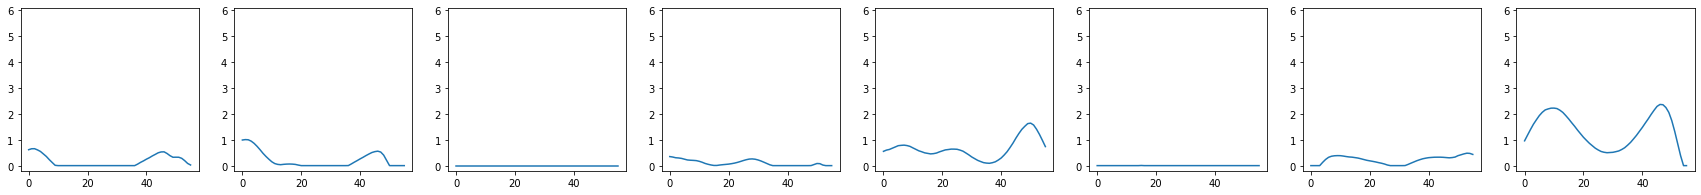

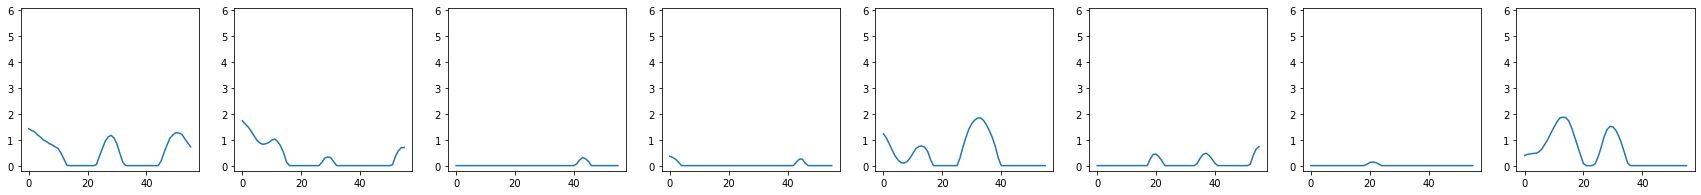

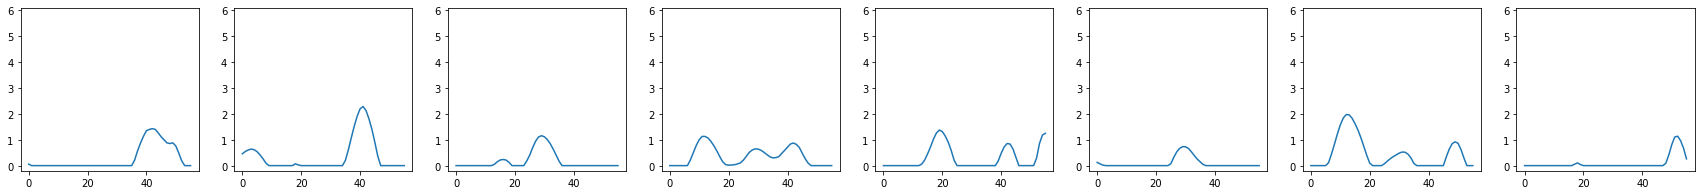

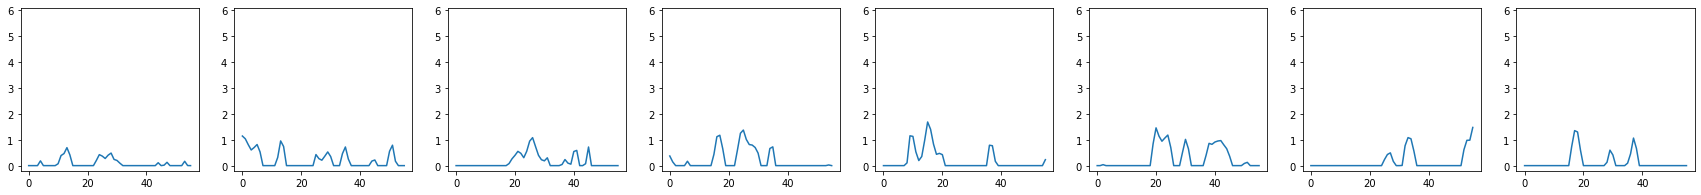

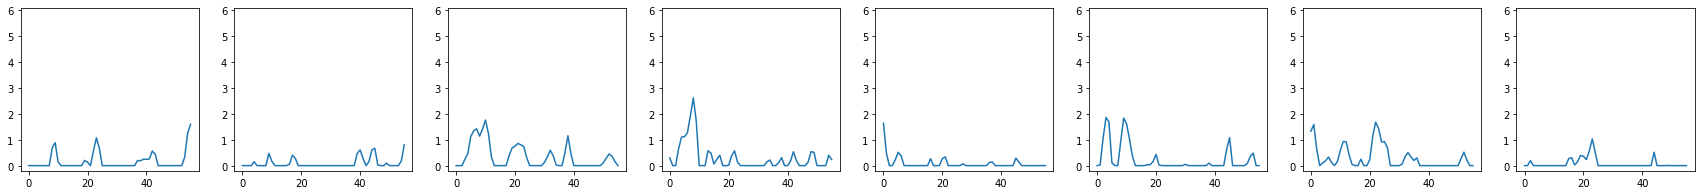

In [42]:
feature_maps = model.predict(np.expand_dims(X_validation[2],axis=0))

for i in range(5):
    pyplot.figure(figsize = (30,3))
    for x in range(filters):
        ax = pyplot.subplot(1, 8, x+1)
        pyplot.ylim(-0.2,6.1)
        pyplot.plot(feature_maps[0, :, i, x])
        ix += 1
    pyplot.show()#Podpisać osie - pasma, czas itp

# Mean maps

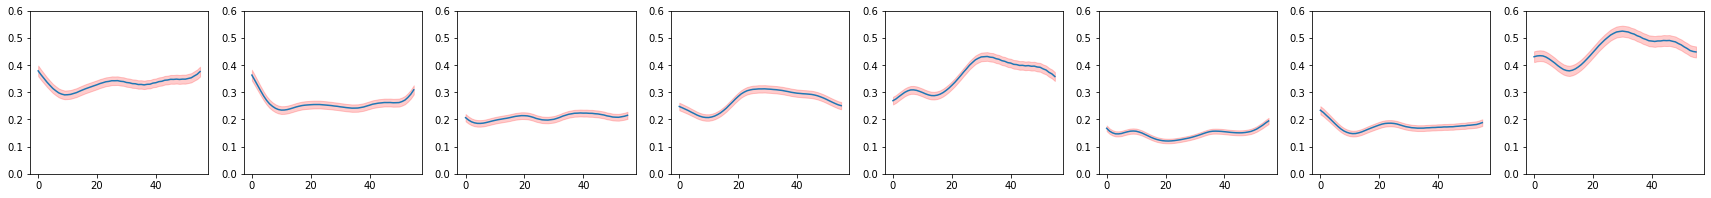

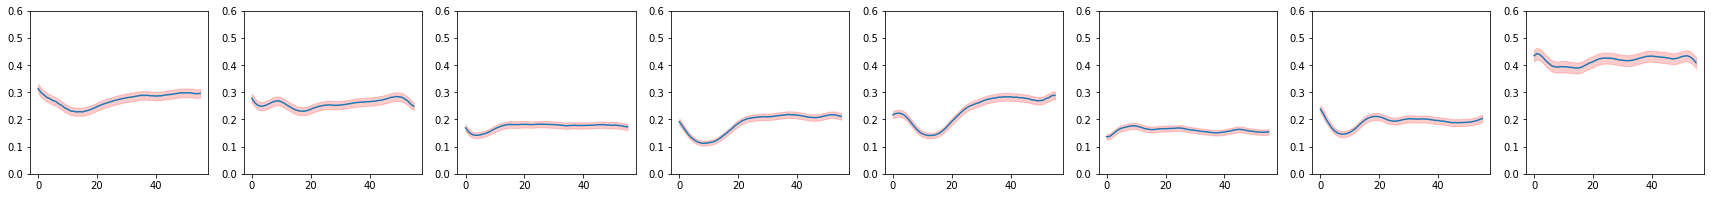

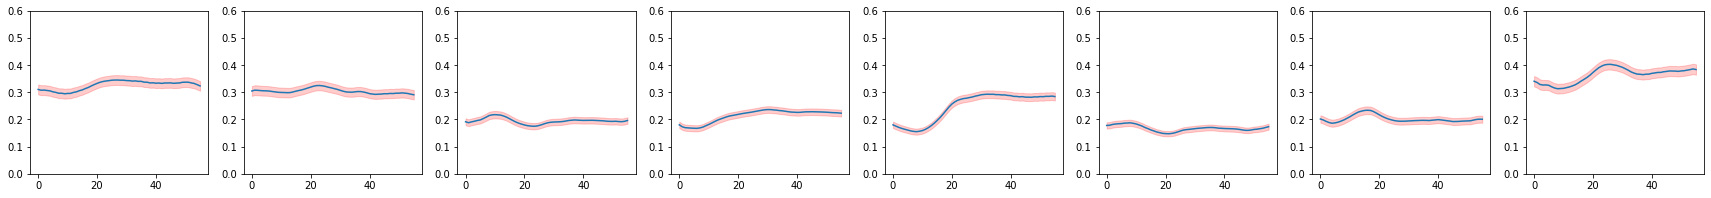

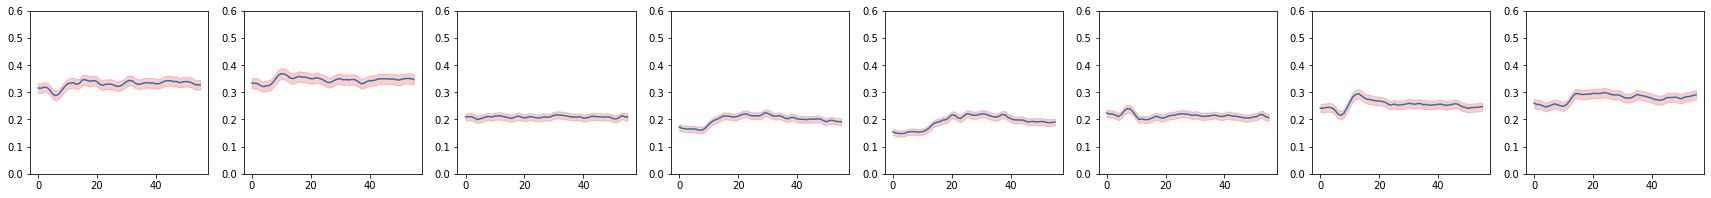

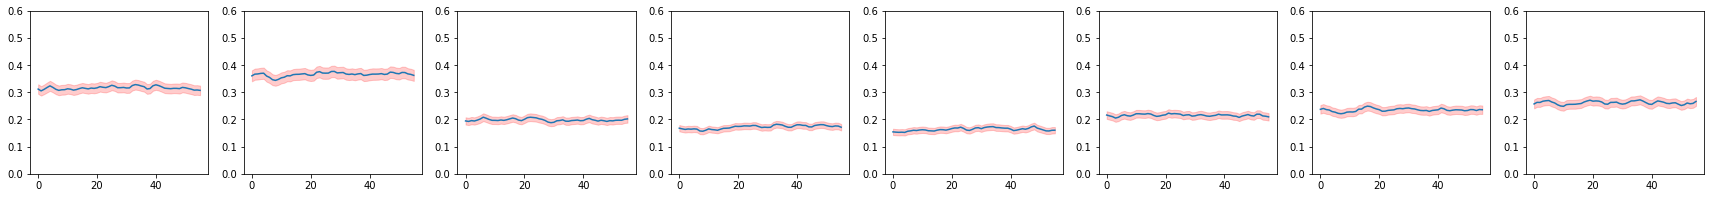

In [43]:
feature_maps = model.predict(X_validation)
plot_features(feature_maps, filters, (0,0.6))

## Dobrze sklasyfikowane

In [44]:
features_maps = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
features_good = features_maps[ind_good]

## Źle sklasyfikowane

In [45]:
features_maps = model.predict(X_validation)
ind_bad = np.where(fitted_model.predict_classes(X_validation) != class_no8)[0]
features_bad = features_maps[ind_bad]

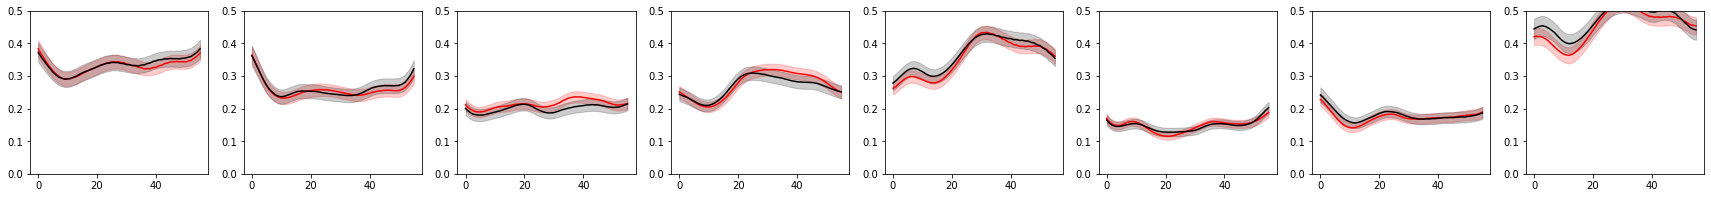

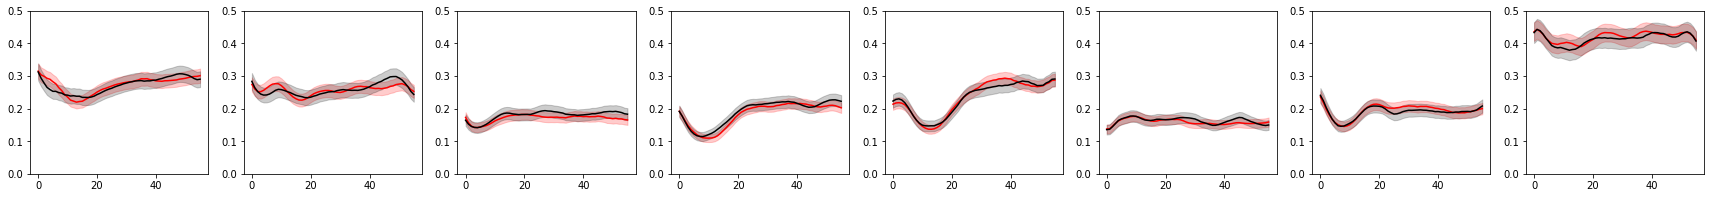

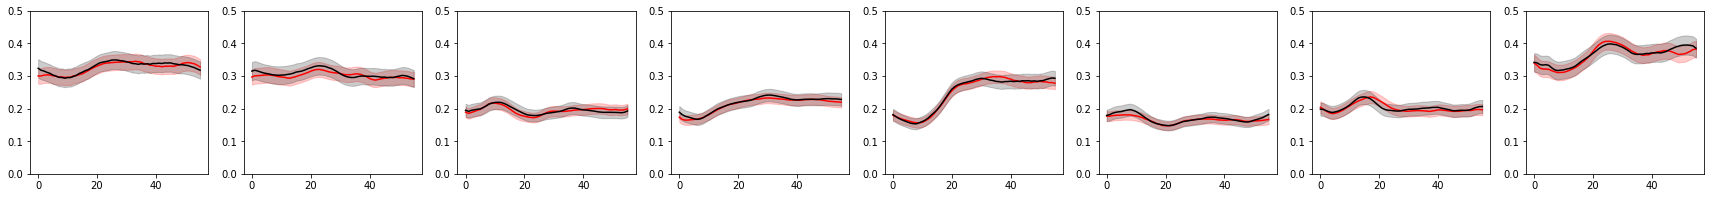

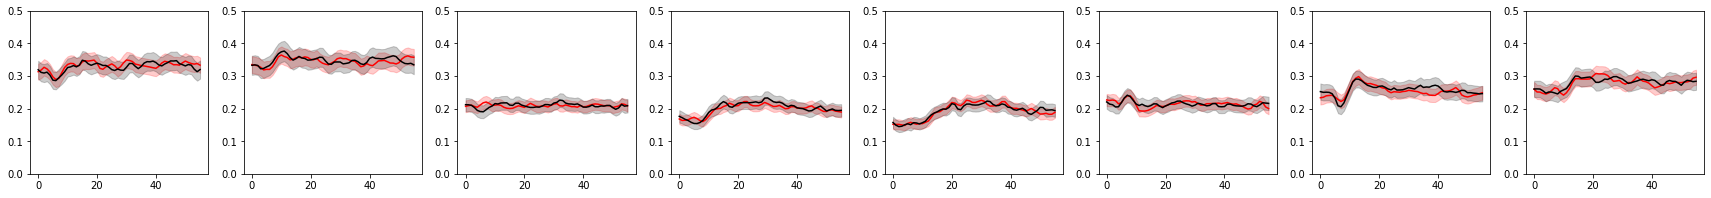

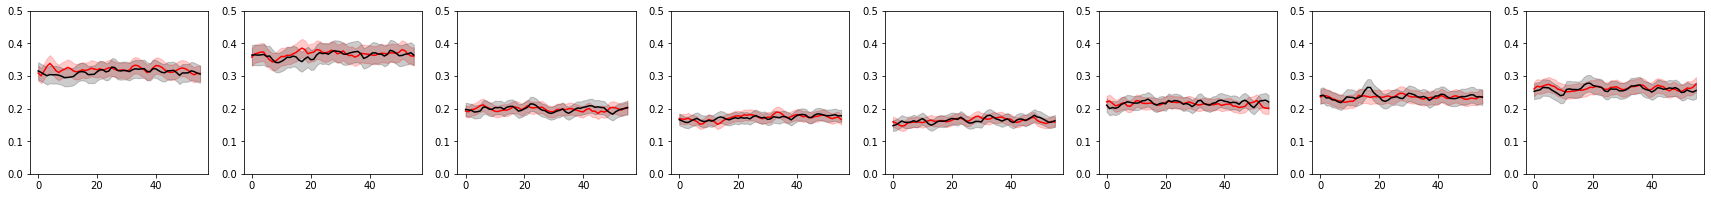

In [46]:
plot_compare_features(features_good, features_bad, filters, (0,0.5))

## Wśród poprawnie zaklasyfikowancyh kategoria 0

In [47]:
features = model.predict(X_validation)
ind_good = np.where(fitted_model.predict_classes(X_validation) == class_no8)[0]
ind_good1 = np.where(class_no8 == 1)[0]
ind_good1 = np.unique(np.concatenate((ind_good, ind_good1)))
ind_good2 = np.where(class_no8 == 0)[0]
ind_good2 = np.unique(np.concatenate((ind_good, ind_good2)))

features_good = features[ind_good]
features_good1 = features[ind_good1]
features_good2 = features[ind_good2]

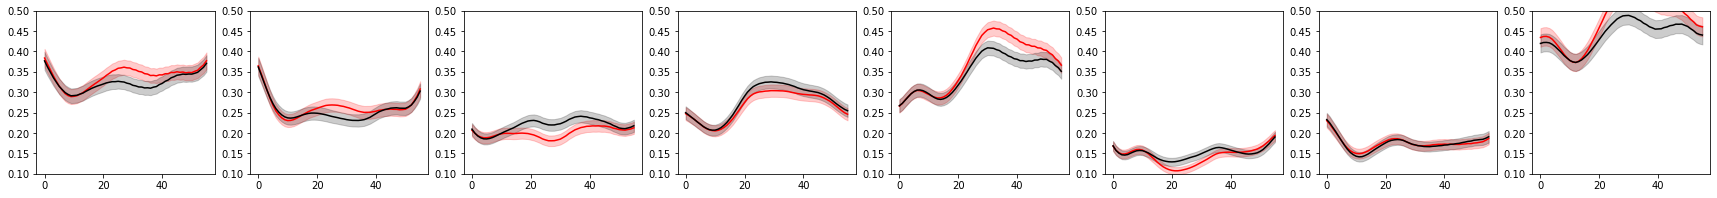

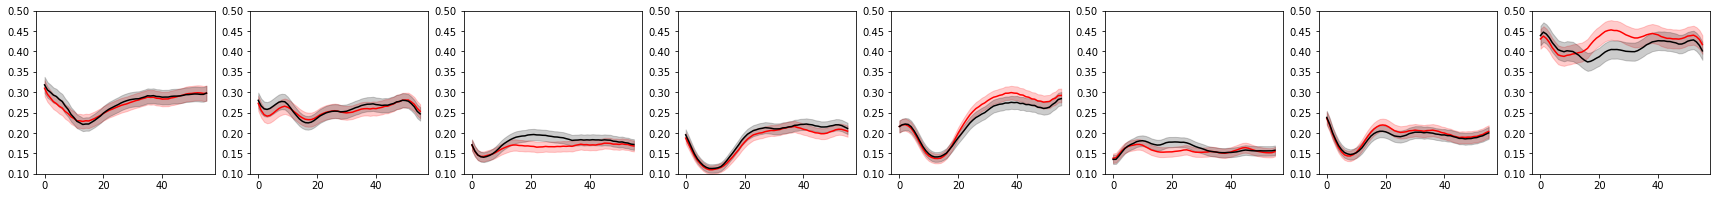

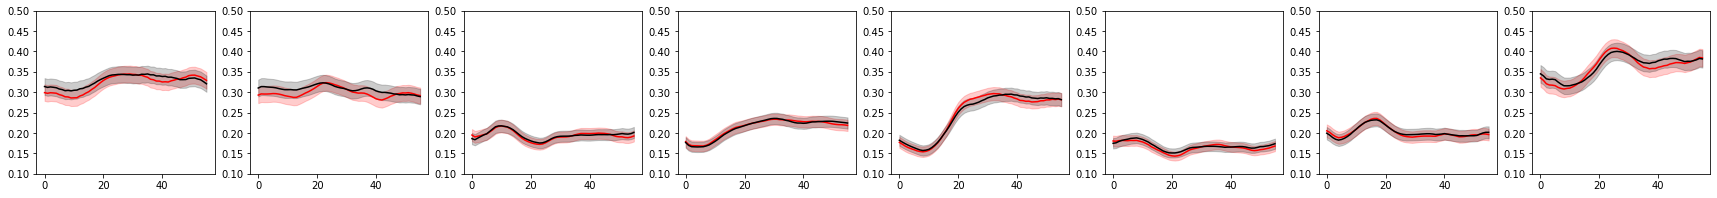

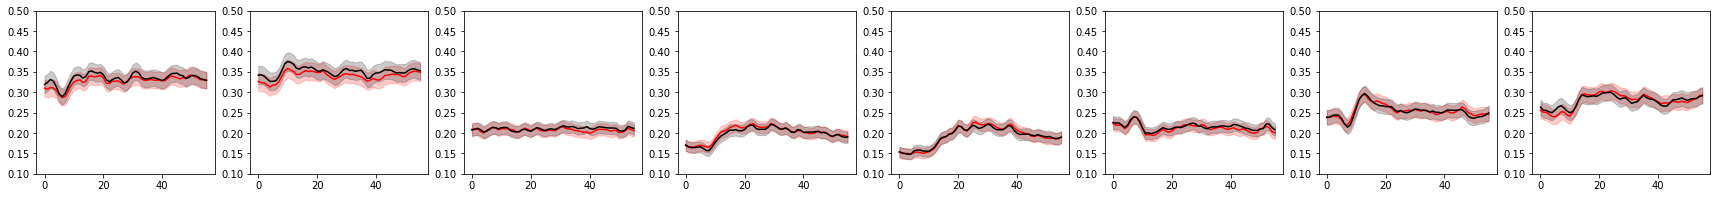

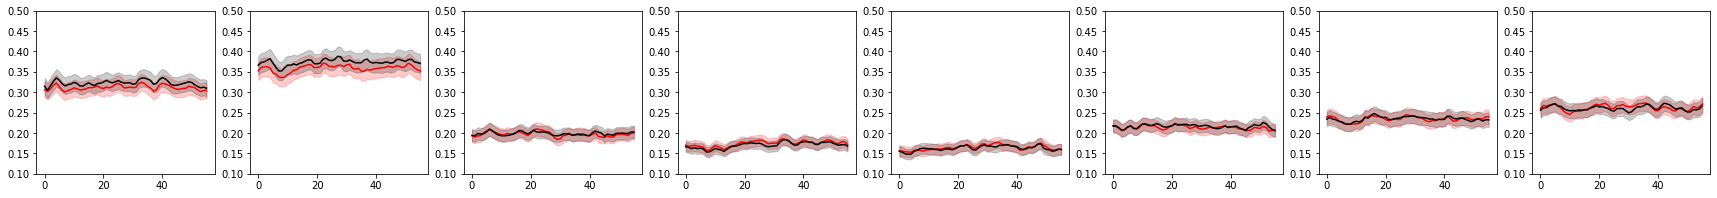

In [48]:
plot_compare_features(features_good1, features_good2, filters, ylim = (0.1,0.5))

In [24]:
#zasłanianie kolejnych fragmentów/pasm i sprw. walidacji (accuracy), można kanały zerować (najlepiej wartość stałą (średnia ze wszystkich?), nie nie brać)
#Macierz pasma x kanały - accuracy/zmianę accuracy (różnicę accuracy od "bazowego") - na raz wyłączam pasmo i dany kanał
#waliduje na sieci nauczonej całymi danymi
#5 sieci - zebrać taką macierz dla każdej i uśrednić (zapisać sobie dla obrazowania) pickle np.

## Collecting votes

In [49]:
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

In [50]:
X_validation = X_validation[:,5:71,:,:]
X_validation.shape

(7464, 66, 5, 19)

Test loss: 0.6821883304837176 / Test accuracy: 0.5568060278892517


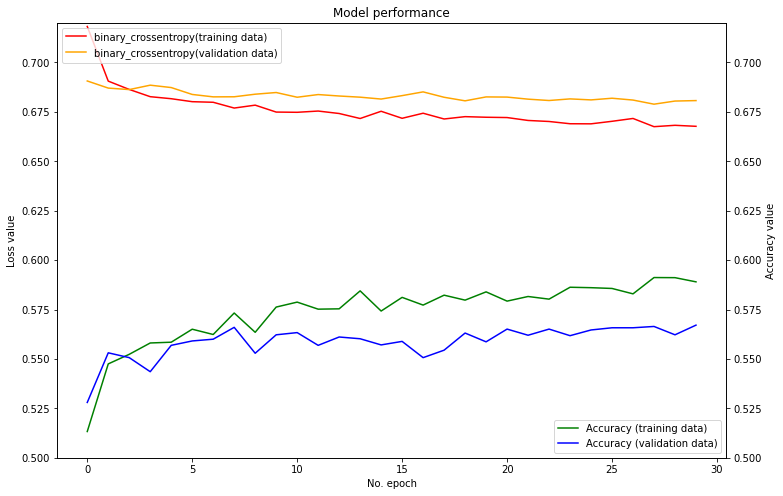

0
Test loss: 0.6814018401046785 / Test accuracy: 0.5557342171669006


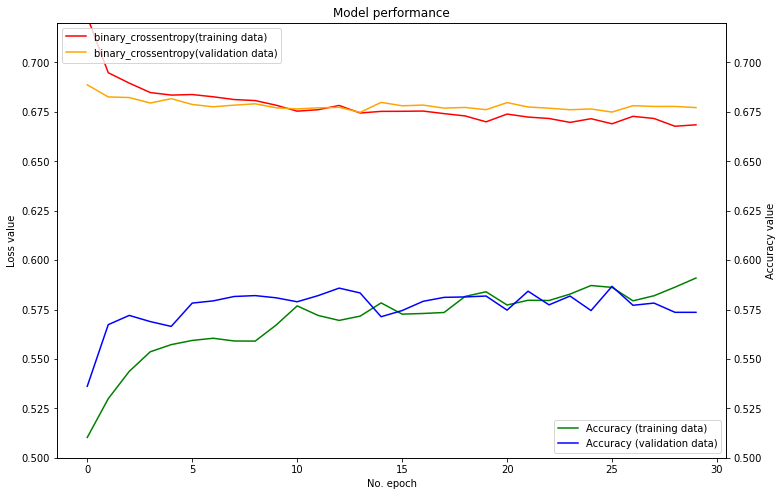

1
Test loss: 0.6802394782359705 / Test accuracy: 0.5661843419075012


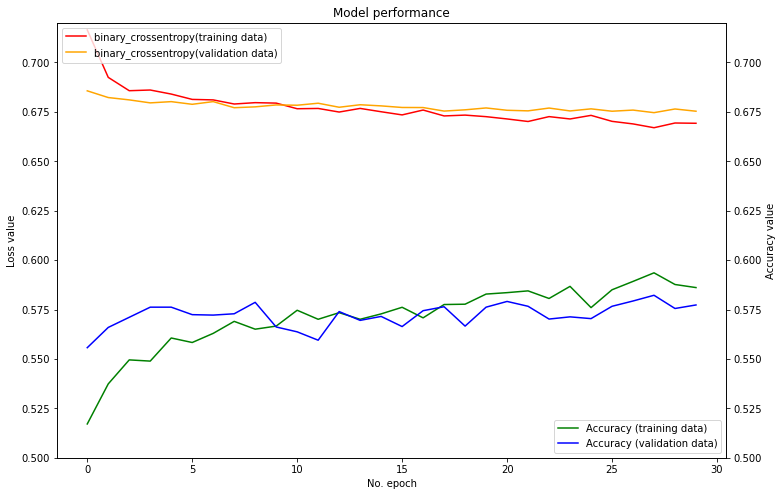

2
Test loss: 0.6813439954898748 / Test accuracy: 0.5668542385101318


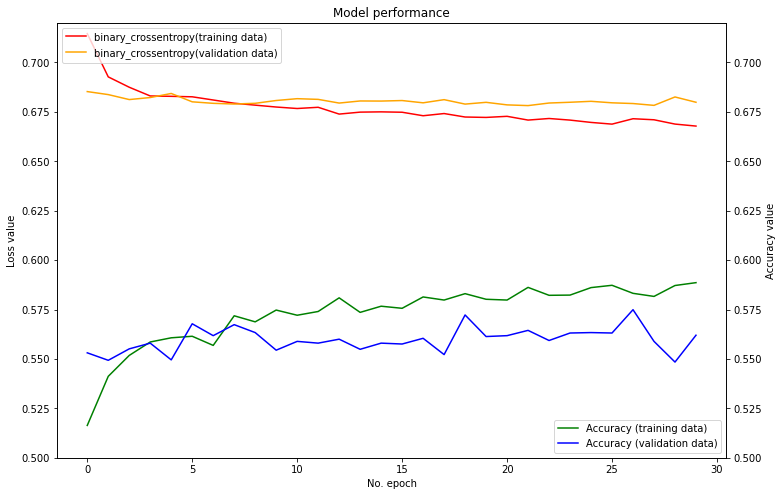

3
Test loss: 0.6824003806834819 / Test accuracy: 0.5562701225280762


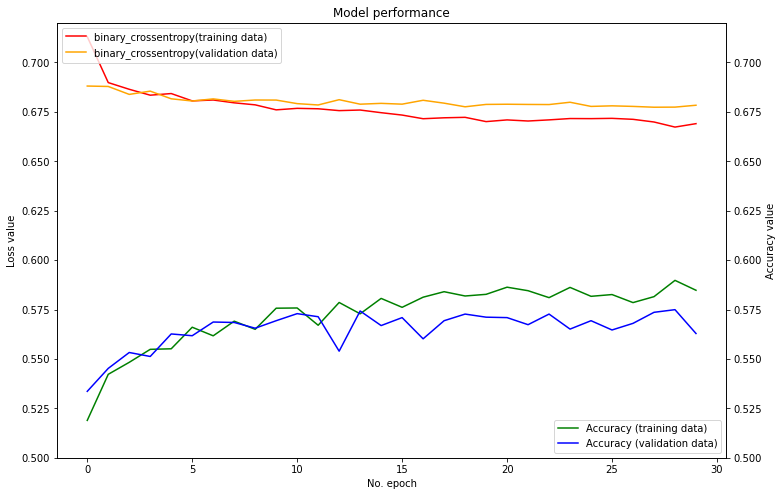

4
0.5687299035369775


In [51]:
batch_size = 200
no_epochs = 30

trials = y_validation.shape[0]
pred = np.zeros((5,trials))
test_loss = []

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i], option)
    X_test, y_test = get_test(X, y, combinations_test[i], option)
    X_train = X_train[:,5:71,:,:]
    X_test = X_test[:,5:71,:,:]
    sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    model = create_model(sample_shape, 2, (11,1),(11,1), 30, 50, optimizer='adam')
    
    fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
                batch_size, no_epochs, verbosity = 0)
    fitted_model.save('./models/model_mix0_'+str(i))
    "Getting validation and loss score"
    score = evaluate(fitted_model, X_validation, y_validation)
    test_loss.append(score)
    "Plotting history"
    plot_history(hist, loss_fun)
    "Saving predictions"
    pred[i] = fitted_model.predict_classes(X_validation)
    print(i)
votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])
acc = score/trials
print(acc)

# OKLUZJA

In [52]:
replacement = np.mean(X_validation, axis = 0)
acc_score = np.empty((5,5,19))

for i in range(5):
    model = load_model('./models/model_mix0_'+str(i))
    score = evaluate(model, X_validation, y_validation)
    acc = score[1]
    for band in range(5):
        for ch in range(19):
            X_temp = X_validation.copy()
            X_temp[:,:,band,ch] = replacement[:,band,ch]
#             X_temp[:,:,band,ch] = 0
            score = evaluate(model, X_temp, y_validation, verbose = 0)
            acc_score[i,band,ch] = acc-score[1]
        print(f'FINISHED BAND: {band}')
    print('FINISHED MODEL ' + str(i))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Test loss: 0.6821883304837176 / Test accuracy: 0.5568060278892517
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 0
Test loss: 0.6814018401046785 / Test accuracy: 0.5557342171669006
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 1
Test loss: 0.6802394782359705 / Test accuracy: 0.5661843419075012
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 2
Test loss: 0.6813439954898748 / Test accuracy: 0.5668542385101318
FINISHED BAND: 0
FINISHED BAND: 1
FINISHED BAND: 2
FINISHED BAND: 3
FINISHED BAND: 4
FINISHED MODEL 3
Test loss: 0.6824003806834819 / Test accuracy: 0.5562701225280762
FINISHED BAND: 0
FINISHED 

In [57]:
# np.save('predictions.npy',prediction)
np.save('acc_score_mix.npy',acc_score)
import matplotlib.colors as mc

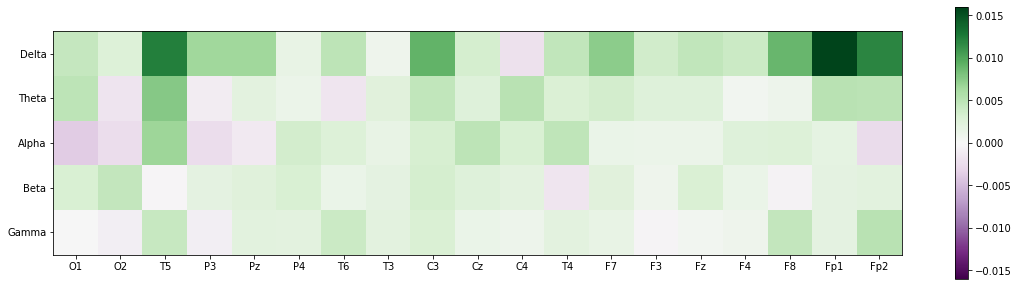

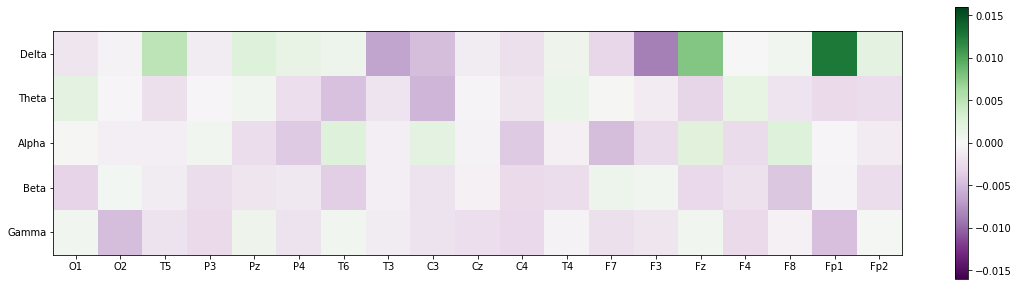

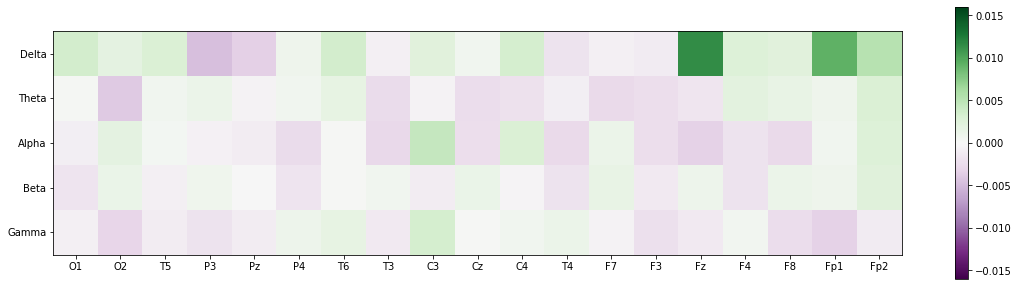

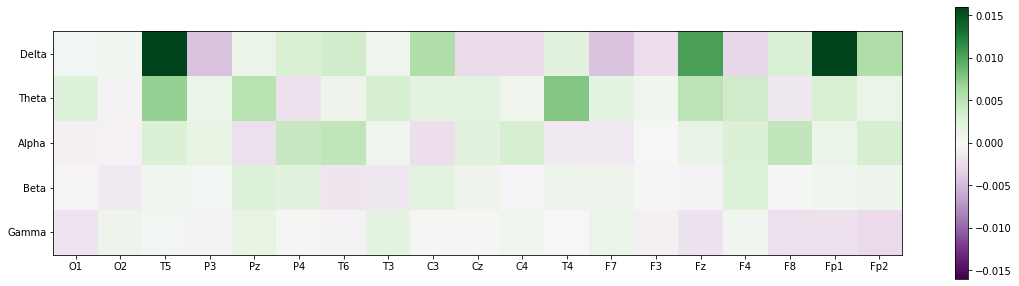

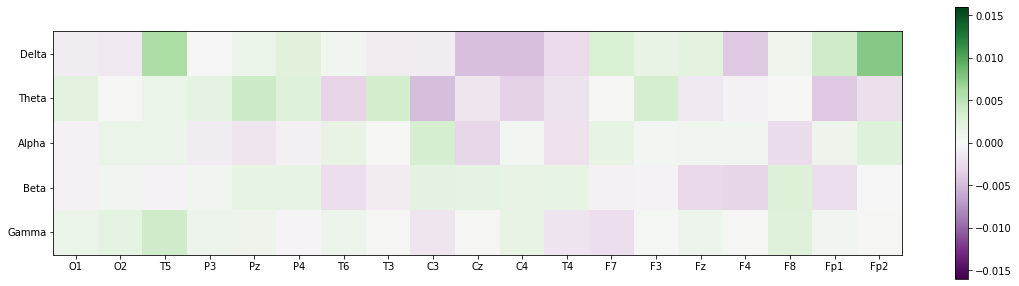

In [4]:
acc_score = np.load('acc_score_mix.npy')
# spróbować wyplotować topoplot główki dla elektrod i poszczególnych pasm
chan = np.load('channels.npy')
for i in range(5):
    plt.figure(figsize = (19,5))
    
    plt.imshow(acc_score[i], cmap = 'PRGn')
    plt.clim(-0.016,0.016)
    plt.yticks(np.arange(5), labels=('Delta', 'Theta', 'Alpha', 'Beta','Gamma'))
    plt.xticks(np.arange(len(chan)), labels=chan)
    plt.colorbar()
    plt.show()

In [5]:
acc_score.shape

(5, 5, 19)

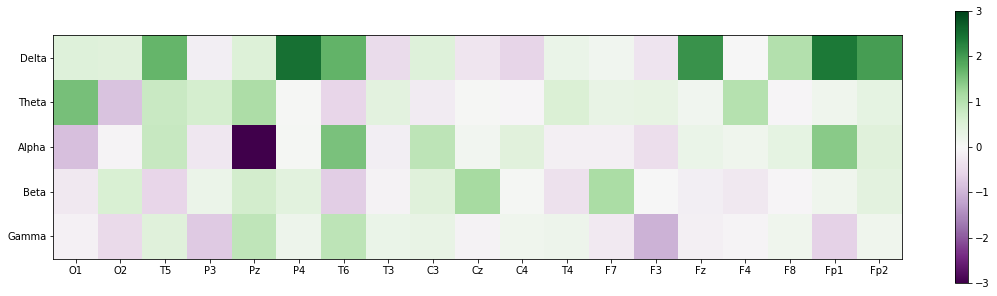

In [6]:
plt.figure(figsize = (19,5))
plt.imshow(np.mean(acc_score, axis=0)/np.std(acc_score, axis=0), cmap = 'PRGn')
plt.clim(-3,3)
plt.xticks(np.arange(len(chan)), labels=chan)
plt.yticks(np.arange(5), labels=('Delta', 'Theta', 'Alpha', 'Beta','Gamma'))
plt.colorbar()
plt.show()
#podpisać nazwami kanałów

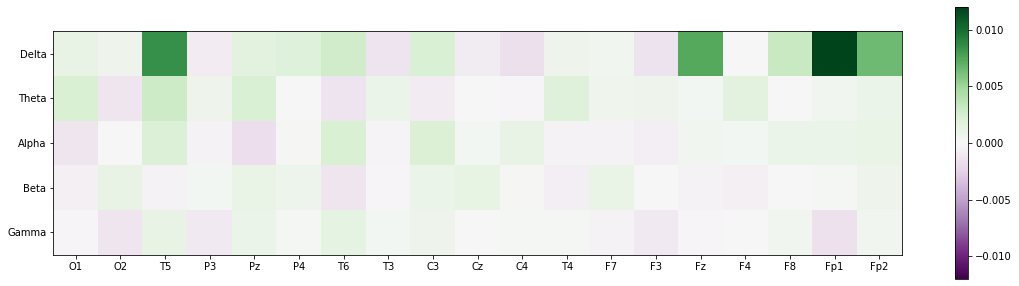

In [11]:
plt.figure(figsize = (19,5))
plt.imshow(np.mean(acc_score, axis=0), cmap = 'PRGn')
plt.clim(-0.012,0.012)
plt.xticks(np.arange(len(chan)), labels=chan)
plt.yticks(np.arange(5), labels=('Delta', 'Theta', 'Alpha', 'Beta','Gamma'))
plt.colorbar()
plt.show()
#podpisać nazwami kanałów

In [61]:
#pod postaciąwartości z - srednia/ std miedzy 5 wartosciami z kazdego modelu

#spróbować zrobić tak jak mieszanie u MAteusza